# Project start
<a href="https://github.com/Bae-ChangHyun"><img src="https://img.shields.io/badge/Github-000000?style=flat&logo=github&logoColor=ffffff&labelColor=000000&link=https%3A%2F%2Fgithub.com%2FBae-ChangHyun"/></a> <br>
<a href="https://changsroad.tistory.com/"><img src="https://img.shields.io/badge/Tistory-f44336?style=flat&logo=tistory&logoColor=ffffff&link=https%3A%2F%2Fchangsroad.tistory.com%2F"/></a> <br>
<a href="mailto:matthew624@naver.com"><img src="https://img.shields.io/badge/Naver-03C75A?style=flat&logo=naver&logoColor=ffffff&link=mailto%3Amatthew624%40naver.com"/></a><br>
<a href="https://dacon.io/competitions/official/236125/overview/description" target="_blank"><img align="center" alt="Dacom" title="Dacon" src="https://image.rocketpunch.com/company/136141/dacon_logo_1673999571.png?s=400x400&t=inside" width="2%" height="2%"></a><br>

# 전력사용량 예측 AI 경진대회


- 건물별 시간당 전력사용량을 예측하는 대회입니다.


- 건물별 전력사용량의 패턴을 파악하는게 핵심인 대회입니다.


- train data와 test data의 시간대가 다른, 시계열 문제입니다. 시계열 문제를 단순 회귀문제로 변환하여 푸는 방법을 알아봅니다.


# 1. 라이브러리, 데이터 불러오기

In [2]:

# 데이터분석 4종 세트
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rc('axes',unicode_minus=False)

import seaborn as sns

# 모델들, 성능 평가
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score,silhouette_score, mean_absolute_percentage_error
from sklearn.cluster import KMeans
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from sklearn.preprocessing import StandardScaler

#import lightgbm as lgb
from lightgbm import LGBMRegressor
#from lightgbm.sklearn import LGBMRegressor

# 상관관계 분석, VIF : 다중공선성 제거
from statsmodels.stats.outliers_influence import variance_inflation_factor

# KFold(CV), partial : optuna를 사용하기 위함
from sklearn.model_selection import KFold
from functools import partial

# hyper-parameter tuning을 위한 라이브러리, optuna
import optuna
from optuna.samplers import TPESampler

from tqdm.notebook import tqdm

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
# flag setting
feature_reducing = False # 'pca' or 'fi'

In [4]:
# 데이터를 불러옵니다.
train = pd.read_csv('data/train.csv')
building_info = pd.read_csv('data/building_info.csv')
test = pd.read_csv('data/test.csv')
print(train.shape, building_info.shape, test.shape)

(204000, 10) (100, 7) (16800, 7)


# 2. EDA
- 데이터에서 찾아야 하는 기초적인 내용들을 확인합니다.

- class imbalance, target distribution, outlier, correlation을 확인합니다.

- num_date_time: 건물번호와 시간

- 일시: 측정일시


In [5]:
# train과 test의 컬럼이 차이가 있음.
train.columns
test.columns

Index(['num_date_time', '건물번호', '일시', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)',
       '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)'],
      dtype='object')

Index(['num_date_time', '건물번호', '일시', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)'], dtype='object')

In [6]:
train = train.drop(columns=['일조(hr)', '일사(MJ/m2)'])
train.columns = ['num_date_time', 'num', 'date_time', 'temperature', 'precipitation','windspeed', 'humidity', 'target']
test.columns = ['num_date_time', 'num', 'date_time', 'temperature', 'precipitation','windspeed', 'humidity']
building_info.columns = ['num', 'type', 'area', 'cooling_area', 'solar', 'ESS', 'PCS']

In [7]:
building_info.replace('-',0,inplace=True)
building_info[building_info.columns.drop('type')]=building_info.drop(['type'],axis=1).apply(lambda x:x.astype('float'))
building_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num           100 non-null    float64
 1   type          100 non-null    object 
 2   area          100 non-null    float64
 3   cooling_area  100 non-null    float64
 4   solar         100 non-null    float64
 5   ESS           100 non-null    float64
 6   PCS           100 non-null    float64
dtypes: float64(6), object(1)
memory usage: 5.6+ KB


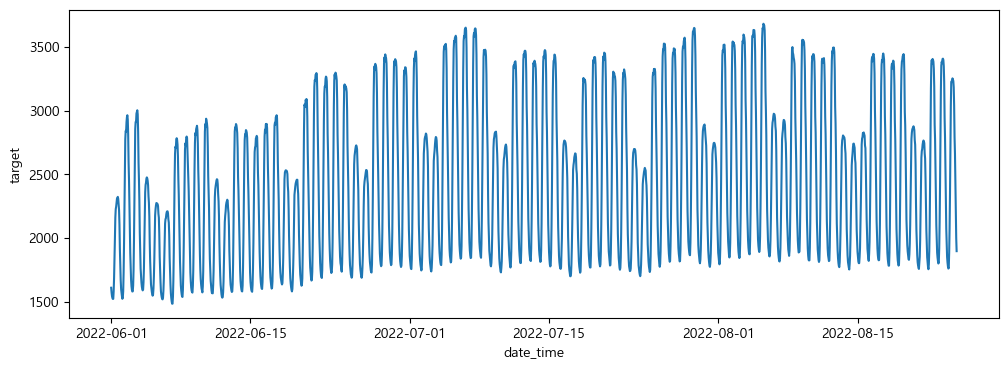

In [8]:
# 전력사용량 패턴
plt.figure(figsize=(12, 4))
train['date_time'] = pd.to_datetime(train['date_time'])
sns.lineplot(data=train, x='date_time', y='target', errorbar=None);

In [9]:
train = pd.merge(train, building_info, on='num', how='inner')
train

num_date_time  num           date_time  temperature  precipitation  \
0         1_20220601 00    1 2022-06-01 00:00:00         18.6            NaN   
1         1_20220601 01    1 2022-06-01 01:00:00         18.0            NaN   
2         1_20220601 02    1 2022-06-01 02:00:00         17.7            NaN   
3         1_20220601 03    1 2022-06-01 03:00:00         16.7            NaN   
4         1_20220601 04    1 2022-06-01 04:00:00         18.4            NaN   
...                 ...  ...                 ...          ...            ...   
203995  100_20220824 19  100 2022-08-24 19:00:00         23.1            NaN   
203996  100_20220824 20  100 2022-08-24 20:00:00         22.4            NaN   
203997  100_20220824 21  100 2022-08-24 21:00:00         21.3            NaN   
203998  100_20220824 22  100 2022-08-24 22:00:00         21.0            NaN   
203999  100_20220824 23  100 2022-08-24 23:00:00         20.7            NaN   

        windspeed  humidity   target    type       area  cooling_area  solar  \
0             0.9      42.0  1085.28    건물기타  110634.00      39570.00    0.0   
1             1.1      45.0  1047.36    건물기타  110634.00      39570.00    0.0   
2             1.5      45.0   974.88    건물기타  110634.00      39570.00    0.0   
3             1.4      48.0   953.76    건물기타  110634.00      39570.00    0.0   
4             2.8      43.0   986.40    건물기타  110634.00      39570.00    0.0   
...           ...       ...      ...     ...        ...           ...    ...   
203995        0.9      86.0   881.04  호텔및리조트   57497.84      40035.23    0.0   
203996        1.3      86.0   798.96  호텔및리조트   57497.84      40035.23    0.0   
203997        1.0      92.0   825.12  호텔및리조트   57497.84      40035.23    0.0   
203998        0.3      94.0   640.08  호텔및리조트   57497.84      40035.23    0.0   
203999        0.1      95.0   540.24  호텔및리조트   57497.84      40035.23    0.0   

        ESS  PCS  
0       0.0  0.0  
1       0.0  0.0  
2       0.0  0.0  
3       0.0  0.0  
4       0.0  0.0  
...     ...  ...  
203995  0.0  0.0  
203996  0.0  0.0  
203997  0.0  0.0  
203998  0.0  0.0  
203999  0.0  0.0  

[204000 rows x 14 columns]

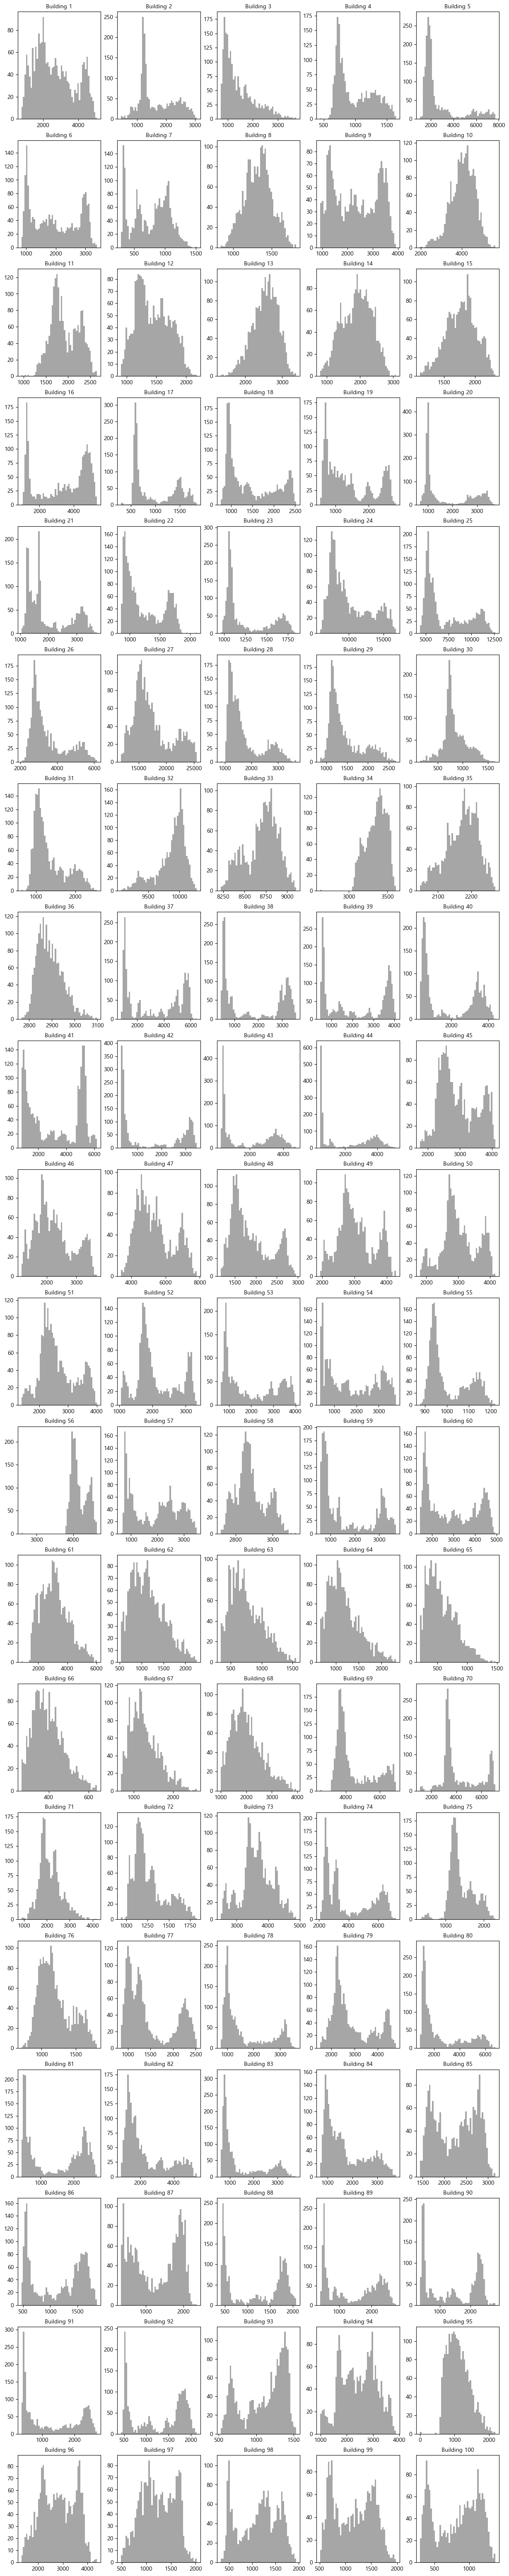

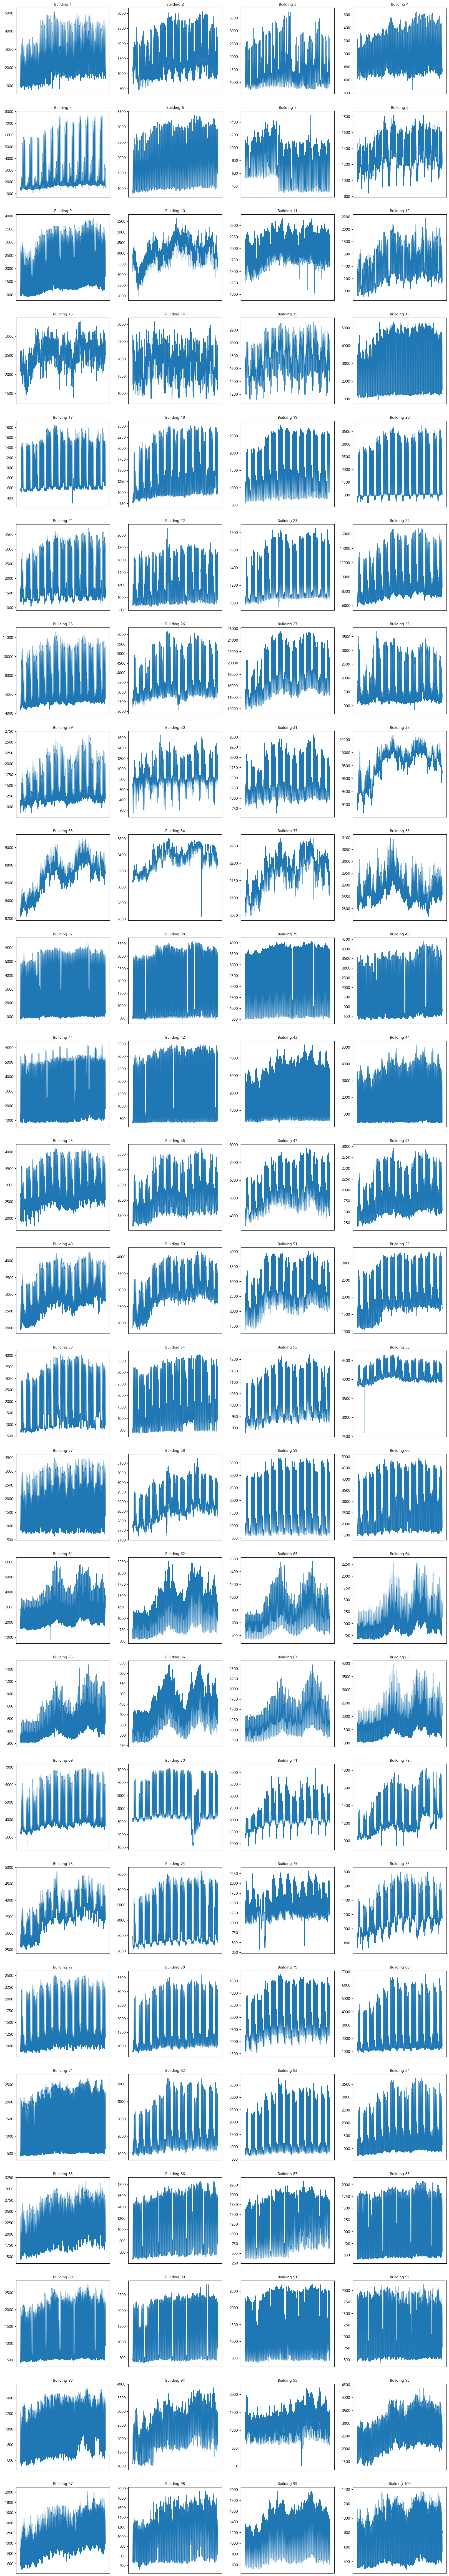

In [10]:
# 건물 유형별로 전력사용량 패턴 보기
# for btype in train.type.unique():
#     plt.figure(figsize=(12, 2))
#     plt.title(btype)
#     b = train[train.type == btype]
#     sns.lineplot(data=b, x="date_time", y='target', errorbar=None)
#     plt.show()

# 건물별로 전력사용량 패턴 보기
# 건물별 전력사용량 패턴 확인! 5 x 12
fig=plt.figure(figsize=(15, 80)) # subplot당 대략 (3, 4)
for n in range(1, 101):
    plt.subplot(20, 5, n)
    plt.title(f"Building {n}", fontsize=10)
    bn_energy = train.loc[train.num == n, "target"] # 2040
    plt.hist(bn_energy, bins=50, alpha=0.7, color='gray')
fig;

fig=plt.figure(figsize=(20, 120)) # subplot당 대략 (3, 6)
for n in range(1, 101):
    plt.subplot(25, 4, n)
    plt.title(f"Building {n}", fontsize=10)
    plt.xticks([])
    bn = train[train.num == n]
    plt.plot(pd.to_datetime(bn.date_time), bn.target)
fig;

## 3. 전처리

1) 모든 건물정보를 다 하나의 데이터에 넣고 하나의 모델로 예측.

- 건물정보를 feature로 넣겠다는 뜻.


2) 건물타입별로 데이터를 나누고, 각각의 모델로 예측.

- 건물타입은 주어진 타입을 사용할 수 있고, 직접 grouping해서 쓸 수도 있음.


3) 건물별로 데이터를 나누고, 각각의 모델로 예측. (모델이 100개)

#### 결측치 처리

In [11]:
# 결측치가 있는 기상정보들의 결측치 채우기
train.info()
train['precipitation'].fillna(0,inplace=True)
train['windspeed'].interpolate(method='linear',inplace=True)
train['humidity'].interpolate(method='linear',inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   num_date_time  204000 non-null  object        
 1   num            204000 non-null  int64         
 2   date_time      204000 non-null  datetime64[ns]
 3   temperature    204000 non-null  float64       
 4   precipitation  43931 non-null   float64       
 5   windspeed      203981 non-null  float64       
 6   humidity       203991 non-null  float64       
 7   target         204000 non-null  float64       
 8   type           204000 non-null  object        
 9   area           204000 non-null  float64       
 10  cooling_area   204000 non-null  float64       
 11  solar          204000 non-null  float64       
 12  ESS            204000 non-null  float64       
 13  PCS            204000 non-null  float64       
dtypes: datetime64[ns](1), float64(10), int64(1), object(

In [12]:
# 건물 전체를 넣어서 모델링하기 위해 건물 타입을 categorical feature로 변환
train=pd.get_dummies(data=train,columns=['type'])

### 시간관련 변수 추가 

Text(0.5, 1.0, 'Elbow Method for Optimal K')

Text(0.5, 0, 'Number of Clusters (K)')

Text(0, 0.5, 'Inertia')

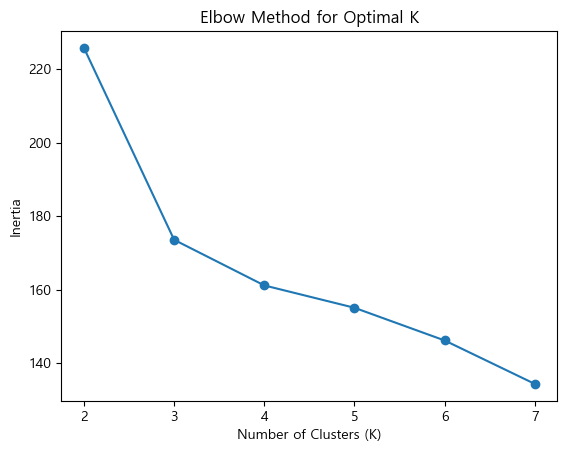

In [23]:
feature_matrix = pd.DataFrame()
display(feature_matrix)
for n in range(1, 101):
    bn = train.loc[train.num == n, 'target'].values
    feature_matrix[n] = bn
feature_matrix

temp = StandardScaler().fit_transform(feature_matrix)
feature_matrix = pd.DataFrame(data=temp, columns=list(range(1, 101))).T

# K에 대한 범위 설정
K_range = range(2, 11)

# 각 K에 대한 inertias와 silhouette_scores 계산
inertia_values = []
for K in tqdm(range(2, 8)):
    kmeans = TimeSeriesKMeans(n_clusters=K, n_init=15,max_iter=200, metric="euclidean", random_state=624,n_jobs=-1,dtw_inertia=True)
    kmeans.fit(feature_matrix)
    inertia_values.append(kmeans.inertia_)

plt.plot(range(2, 8), inertia_values, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()

# 최적의 클러스터 수로 모델 학습 후 실루엣 스코어 계산
# optimal_k =  # 여기에 엘보우 메서드로 찾은 최적의 K 값 입력
# model = TimeSeriesKMeans(n_clusters=optimal_k, max_iter=100, n_init=15, metric="dtw", random_state=624)
# labels = model.fit_predict(feature_matrix)
# silhouette_avg = silhouette_score(feature_matrix, labels, metric="dtw", random_state=624)

# print(f"Optimal K (from Elbow Method): {optimal_k}")
# print(f"Silhouette Score: {silhouette_avg}")

In [24]:
ts_knn = TimeSeriesKMeans(n_clusters=3, metric="dtw", verbose=True,random_state=624,n_jobs=-1)
# 모델 학습
ts_knn=ts_knn.fit(feature_matrix)
cluster_list=ts_knn.predict(feature_matrix)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Do

227.164 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.2s finished


127.668 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.2s finished


124.916 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.4s finished


124.913 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.2s finished


124.913 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.2s finished


In [26]:
cluster_info = pd.DataFrame({'num' : [i for i in range(1, 101)], 'cluster' : cluster_list})

In [27]:
train = pd.merge(train, cluster_info, on="num")

In [30]:
def is_working(hour):
    # hour : 각 row별 시간.
    if 8 <= hour <= 19: # 일과시간
        return 1
    else:               # 휴식
        return 0 
    
def is_weekend(dow):
    # dow(day of week) : 각 row별 요일. (0-월요일, 6-일요일)
    if dow in [5, 6]: # 주말(토요일, 일요일)
        return 1
    else:             # 주중
        return 0

train['month']=train['date_time'].dt.month
#train['hour']=train['date_time'].dt.hour
train['dow'] = train.date_time.dt.day_of_week # 0 ~ 6 : 월~일
train["day"] = train.date_time.dt.day
train["is_working"] = train.date_time.dt.hour.apply(is_working)
#train["is_weekend"] = train.date_time.dt.day_of_week.apply(is_weekend)
train

num_date_time  num           date_time  temperature  precipitation  \
0         1_20220601 00    1 2022-06-01 00:00:00         18.6            0.0   
1         1_20220601 01    1 2022-06-01 01:00:00         18.0            0.0   
2         1_20220601 02    1 2022-06-01 02:00:00         17.7            0.0   
3         1_20220601 03    1 2022-06-01 03:00:00         16.7            0.0   
4         1_20220601 04    1 2022-06-01 04:00:00         18.4            0.0   
...                 ...  ...                 ...          ...            ...   
203995  100_20220824 19  100 2022-08-24 19:00:00         23.1            0.0   
203996  100_20220824 20  100 2022-08-24 20:00:00         22.4            0.0   
203997  100_20220824 21  100 2022-08-24 21:00:00         21.3            0.0   
203998  100_20220824 22  100 2022-08-24 22:00:00         21.0            0.0   
203999  100_20220824 23  100 2022-08-24 23:00:00         20.7            0.0   

        windspeed  humidity   target       area  cooling_area  ...  type_아파트  \
0             0.9      42.0  1085.28  110634.00      39570.00  ...     False   
1             1.1      45.0  1047.36  110634.00      39570.00  ...     False   
2             1.5      45.0   974.88  110634.00      39570.00  ...     False   
3             1.4      48.0   953.76  110634.00      39570.00  ...     False   
4             2.8      43.0   986.40  110634.00      39570.00  ...     False   
...           ...       ...      ...        ...           ...  ...       ...   
203995        0.9      86.0   881.04   57497.84      40035.23  ...     False   
203996        1.3      86.0   798.96   57497.84      40035.23  ...     False   
203997        1.0      92.0   825.12   57497.84      40035.23  ...     False   
203998        0.3      94.0   640.08   57497.84      40035.23  ...     False   
203999        0.1      95.0   540.24   57497.84      40035.23  ...     False   

        type_연구소  type_지식산업센터  type_할인마트  type_호텔및리조트  cluster  month  dow  \
0          False        False      False        False        2      6    2   
1          False        False      False        False        2      6    2   
2          False        False      False        False        2      6    2   
3          False        False      False        False        2      6    2   
4          False        False      False        False        2      6    2   
...          ...          ...        ...          ...      ...    ...  ...   
203995     False        False      False         True        0      8    2   
203996     False        False      False         True        0      8    2   
203997     False        False      False         True        0      8    2   
203998     False        False      False         True        0      8    2   
203999     False        False      False         True        0      8    2   

        day  is_working  
0         1           0  
1         1           0  
2         1           0  
3         1           0  
4         1           0  
...     ...         ...  
203995   24           1  
203996   24           0  
203997   24           0  
203998   24           0  
203999   24           0  

[204000 rows x 30 columns]

### 군집분류 - K-means

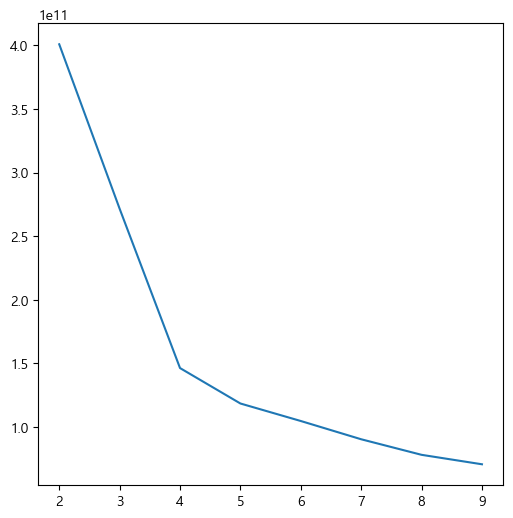

In [ ]:
cluster_df=pd.DataFrame()

# bn=건물번호
for bn in range(1,101):
    cluster_df[bn]=train.loc[train.num==bn,'target'].values
cluster_df=cluster_df.T
cluster_df

# elbow_method
inertias=[]
labels=[]
for K in range(2, 10):
    km=KMeans(n_clusters=K,init='k-means++',n_init='auto',random_state=624)
    km=km.fit(cluster_df)
    inertias.append(km.inertia_)
    labels.append(km.predict(cluster_df))
plt.figure(figsize=(6, 6))
plt.plot(range(2,10), inertias)
plt.xticks(range(2,10))
plt.show();

In [ ]:
optimal_k = 4
cluster_list = labels[optimal_k-2]

cluster_df = pd.DataFrame({'num' : np.arange(1, 101),'cluster' : cluster_list})
train = pd.merge(train, cluster_df, on='num')
#train

In [33]:
train[train['cluster']==0].shape 
train[train['cluster']==1].shape 
train[train['cluster']==2].shape 

(63240, 30)

(89760, 30)

(51000, 30)

In [55]:
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

def split_data(cluster_num):
    # 첫번째 테스트용으로 사용하고, 실제 학습시에는 K-Fold CV를 사용합니다.
    X = train[train.cluster == cluster_num].drop(columns=['num_date_time', 'date_time', 'target', 'cluster'])
    y = train[train.cluster == cluster_num].target

    # for OOF(out-of-fold)-prediction split 5% of data as validation dataset.
    # -> kfold cv에 사용하지 않은 작은 데이터로 최종 검증을 해보는 방법.
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=624)
    print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)
    
    return X_train, X_val, y_train, y_val

def train_evaluate(cluster_num,params_list,X_train, X_val, y_train, y_val):
    params=params_list[cluster_num]
    model = LGBMRegressor(**params,verbose=-1)
    model.fit(X_train,y_train)
    y_pred_train= model.predict(X_train)
    y_pred_val = model.predict(X_val)

    train_score = smape(y_train, y_pred_train)
    val_score = smape(y_val, y_pred_val)

    print("Base train Score : %.4f" % train_score)
    print("Base validation Score : %.4f" % val_score)
    
    return model
    
def objective(trial, X, y, K,params):
    
    params_optuna={
        "num_leaves" : trial.suggest_categorical('num_leaves',params['num_leaves']),
        "max_depth" : trial.suggest_int('max_depth',params['max_depth'][0],params['max_depth'][1]),
        "learning_rate" : trial.suggest_float('learning_rate',params['learning_rate'][0],params['learning_rate'][1]),
        "n_estimators": trial.suggest_int('n_estimators',params['n_estimators'][0],params['n_estimators'][1]),
        "min_child_samples" : trial.suggest_int('min_child_samples',params['min_child_samples'][0],params['min_child_samples'][1]),
        "reg_lambda" : trial.suggest_float('reg_lambda',params['reg_lambda'][0],params['reg_lambda'][1]),
        "colsample_bytree"  : trial.suggest_categorical('colsample_bytree',params['colsample_bytree']),
        "device":'gpu',
    }
    model = LGBMRegressor(**params_optuna,verbose=-1)

    # K-Fold Cross validation을 구현합니다.
    folds = KFold(n_splits=K, random_state=624, shuffle=True)
    losses = []

    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]

        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        loss = smape(y_val, preds)
        losses.append(loss)
        
    return np.mean(losses)
    
def tune_parameter(cluster_num,optuna_params_list,X_train, y_train):
    K = 5   
    opt_func = partial(objective, X=X_train, y=y_train, K=K,params=optuna_params_list[cluster_num]) # optuna에 인자를 넘기고 싶을 경우

    K = 5 # Kfold 수
    sampler = TPESampler(seed=624)
    study = optuna.create_study(direction="minimize", # 최소/최대 어느 방향의 최적값을 구할 건지.
                                sampler=sampler,
                                storage="sqlite:///db.sqlite3",
                                study_name=f"{cluster_num}_train(23.11.30)",
                                load_if_exists=True) 
    study.optimize(opt_func, n_trials=70)
    
    print("Tuned train Score: %.4f" % study.best_value) # best score 출력
    print("Tuned params: ", study.best_trial.params) # best score일 때의 하이퍼파라미터들
    
    return study

def finalize_train(study,X_train, X_val, y_train, y_val):
    best_params = study.best_params
    best_params["device"]='gpu'
    best_model = LGBMRegressor(**best_params,random_state=624,verbose=-1)
    best_model.fit(X_train, y_train)
    print("Tuned Validation Score : %.4f" % smape(y_val, best_model.predict(X_val)))
    
    return best_model

def show_feature_importance(best_model):
    fi_df = pd.DataFrame({'features' : best_model.feature_name_,'importances' : best_model.feature_importances_})
    fi_df.sort_values(by='importances',ascending=False,inplace=True)

    plt.figure(figsize=(10, 6))
    plt.bar(fi_df['features'], fi_df['importances'])
    plt.xlabel('Feature Names')
    plt.ylabel('Importances')
    plt.title('Feature Importances')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
    plt.tight_layout()
    plt.show();

def train_models(cluster_num_list,train,params_list,optuna_params_list):
    study_list=[]
    base_models=[]
    best_models=[]
    
    for c_num in cluster_num_list:
        print('#'*100)
        print(f"Cluster {c_num} train Start")
        X_train, X_val, y_train, y_val = split_data(c_num)
        base_model=train_evaluate(c_num,params_list,X_train, X_val, y_train, y_val)
        study=tune_parameter(c_num,optuna_params_list,X_train, y_train)
        best_model=finalize_train(study,X_train, X_val, y_train, y_val)
        show_feature_importance(best_model)
        
        study_list.append(study)
        base_models.append(base_model)
        best_models.append(best_model)
        print(f"Cluster {c_num} train is Completed")
        print('#'*100)
    
    return study_list, base_models, best_models

In [49]:
params_cluster0={
        "num_leaves" : 1023,
        "max_depth" : 10,
        "learning_rate" : 0.23,
        "n_estimators": 50,
        "min_child_samples" :10,
        "reg_lambda" : 7,
        "colsample_bytree" : 0.5,
        "device":'gpu',
        'random_state':624
}
params_cluster1={
        "num_leaves" : 511,
        "max_depth" : 7,
        "learning_rate" : 0.2,
        "n_estimators": 50,
        "min_child_samples" :10,
        "reg_lambda" : 5,
        "colsample_bytree" : 0.5,
        "device":'gpu',
        'random_state':624
}
params_cluster2={
        "num_leaves" : 1023,
        "max_depth" : 12,
        "learning_rate" : 0.3,
        "n_estimators": 100,
        "min_child_samples" :20,
        "reg_lambda" : 5,
        "colsample_bytree" : 0.5,
        "device":'gpu',
        'random_state':624
}
params_cluster3={
        "num_leaves" : 127,
        "max_depth" : 5,
        "learning_rate" : 0.3,
        "n_estimators": 50,
        "min_child_samples" :10,
        "reg_lambda" : 1,
        "colsample_bytree" : 0.5,
        "device":'gpu',
        'random_state':624
}
params_list= [params_cluster0,params_cluster1,params_cluster2]

In [50]:
optuna_params_cluster2={
    "num_leaves" : [2**9-1, 2**10-1, 2**11-1],
    "max_depth" : (8,15),
    "learning_rate" : (0.01,0.1),
    "n_estimators": (50,200),
    "min_child_samples" :(10,25),
    "reg_lambda" : (5.0,20.0),
    "colsample_bytree"  : [0.5,0.7],
    "device":'gpu',
}
optuna_params_cluster3={
    "num_leaves" : [2**7-1, 2**8-1, 2**9-1],
    "max_depth" : (10,15),
    "learning_rate" : (0.01,0.1),
    "n_estimators": (50,200),
    "min_child_samples" :(10,25),
    "reg_lambda" : (5.0,20.0),
    "colsample_bytree"  : [0.5,0.7],
    "device":'gpu',
}
optuna_params_cluster0={
    "num_leaves" : [2**9-1, 2**10-1, 2**11-1],
    "max_depth" : (10,15),
    "learning_rate" : (0.01,0.1),
    "n_estimators": (50,200),
    "min_child_samples" :(10,25),
    "reg_lambda" : (5.0,20.0),
    "colsample_bytree"  : [0.5,0.7],
    "device":'gpu',
}
optuna_params_cluster1={
    "num_leaves" : [2**6-1, 2**7-1, 2**8-1],
    "max_depth" : (5,10),
    "learning_rate" : (0.01,0.1),
    "n_estimators": (20,50),
    "min_child_samples" :(10,25),
    "reg_lambda" : (5.0,20.0),
    "colsample_bytree"  : [0.5,0.7],
    "device":'gpu',
}
optuna_params_list= [optuna_params_cluster0,optuna_params_cluster1,optuna_params_cluster2]

####################################################################################################
Cluster 0 train Start
(60078, 26) (60078,) (3162, 26) (3162,)


[I 2023-12-01 13:00:11,675] A new study created in RDB with name: 0_train(23.11.30)


Base train Score : 12.9645
Base validation Score : 15.4666


[I 2023-12-01 13:00:31,796] Trial 0 finished with value: 23.606532809676377 and parameters: {'num_leaves': 1023, 'max_depth': 11, 'learning_rate': 0.01955085958713234, 'n_estimators': 118, 'min_child_samples': 10, 'reg_lambda': 11.975391055543565, 'colsample_bytree': 0.5}. Best is trial 0 with value: 23.606532809676377.
[I 2023-12-01 13:00:44,471] Trial 1 finished with value: 19.034605454376297 and parameters: {'num_leaves': 1023, 'max_depth': 10, 'learning_rate': 0.038800648091999665, 'n_estimators': 98, 'min_child_samples': 19, 'reg_lambda': 14.550606862915657, 'colsample_bytree': 0.5}. Best is trial 1 with value: 19.034605454376297.
[I 2023-12-01 13:00:52,379] Trial 2 finished with value: 18.826877457965907 and parameters: {'num_leaves': 511, 'max_depth': 10, 'learning_rate': 0.06954900945638207, 'n_estimators': 55, 'min_child_samples': 16, 'reg_lambda': 14.176719571176871, 'colsample_bytree': 0.5}. Best is trial 2 with value: 18.826877457965907.
[I 2023-12-01 13:01:17,715] Trial 3 

Tuned train Score: 14.0349
Tuned params:  {'num_leaves': 2047, 'max_depth': 15, 'learning_rate': 0.06561788482007107, 'n_estimators': 200, 'min_child_samples': 10, 'reg_lambda': 10.273864721431277, 'colsample_bytree': 0.7}
Tuned Validation Score : 13.0826


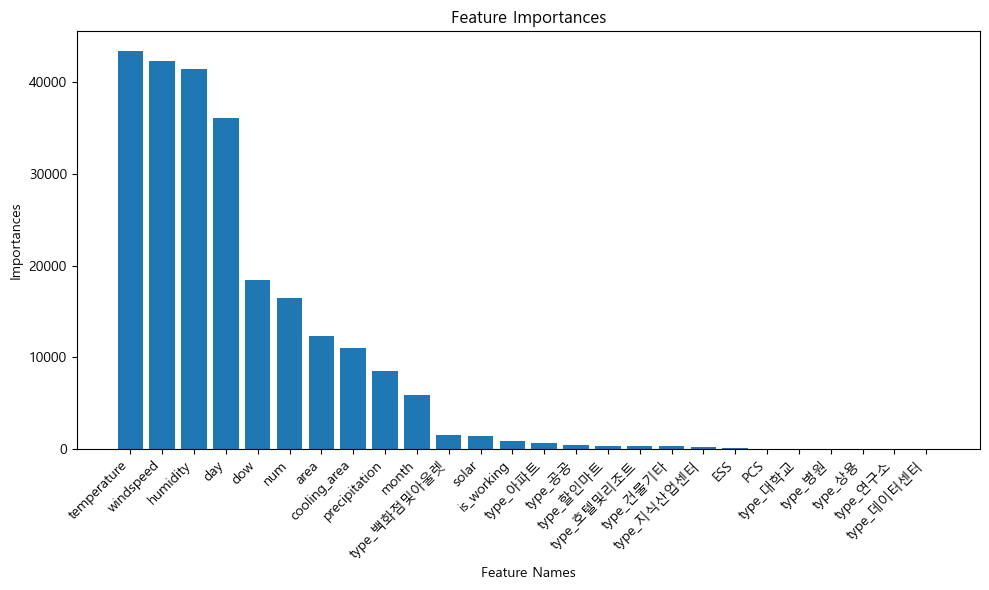

Cluster 0 train is Completed
####################################################################################################
####################################################################################################
Cluster 1 train Start
(85272, 26) (85272,) (4488, 26) (4488,)


[I 2023-12-01 14:23:23,014] A new study created in RDB with name: 1_train(23.11.30)


Base train Score : 10.5358
Base validation Score : 10.9922


[I 2023-12-01 14:23:24,612] Trial 0 finished with value: 41.5118018741492 and parameters: {'num_leaves': 127, 'max_depth': 6, 'learning_rate': 0.01955085958713234, 'n_estimators': 33, 'min_child_samples': 10, 'reg_lambda': 11.975391055543565, 'colsample_bytree': 0.5}. Best is trial 0 with value: 41.5118018741492.
[I 2023-12-01 14:23:25,890] Trial 1 finished with value: 35.002806325884166 and parameters: {'num_leaves': 127, 'max_depth': 5, 'learning_rate': 0.038800648091999665, 'n_estimators': 30, 'min_child_samples': 19, 'reg_lambda': 14.550606862915657, 'colsample_bytree': 0.5}. Best is trial 1 with value: 35.002806325884166.
[I 2023-12-01 14:23:27,010] Trial 2 finished with value: 31.87244245338813 and parameters: {'num_leaves': 63, 'max_depth': 5, 'learning_rate': 0.06954900945638207, 'n_estimators': 21, 'min_child_samples': 16, 'reg_lambda': 14.176719571176871, 'colsample_bytree': 0.5}. Best is trial 2 with value: 31.87244245338813.
[I 2023-12-01 14:23:28,742] Trial 3 finished with

Tuned train Score: 10.9181
Tuned params:  {'num_leaves': 255, 'max_depth': 10, 'learning_rate': 0.09685276070091228, 'n_estimators': 50, 'min_child_samples': 15, 'reg_lambda': 7.127610485773211, 'colsample_bytree': 0.7}
Tuned Validation Score : 10.7579


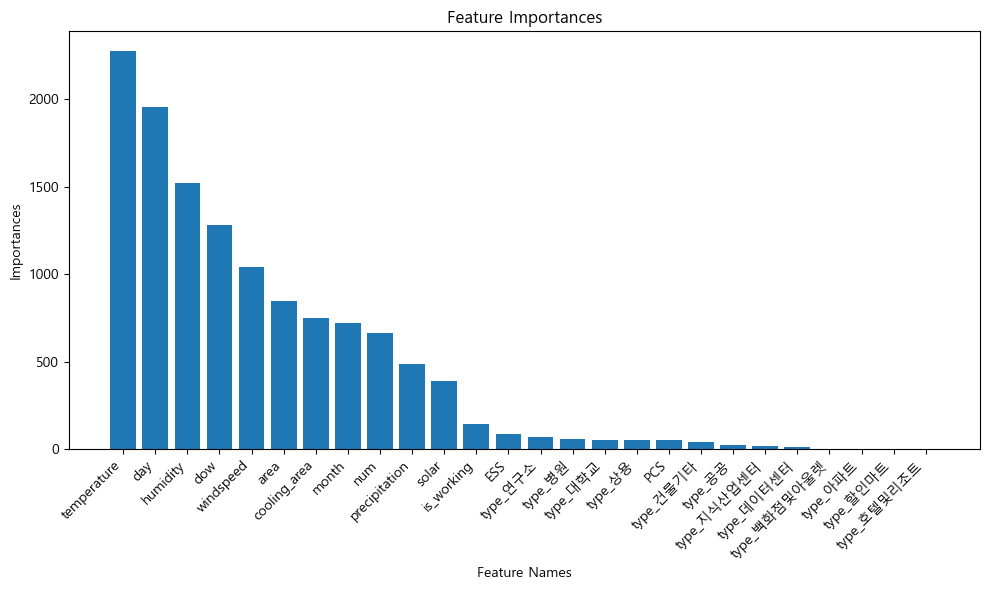

Cluster 1 train is Completed
####################################################################################################
####################################################################################################
Cluster 2 train Start
(48450, 26) (48450,) (2550, 26) (2550,)


[I 2023-12-01 14:27:57,265] A new study created in RDB with name: 2_train(23.11.30)


Base train Score : 6.6490
Base validation Score : 10.7643


[I 2023-12-01 14:28:08,154] Trial 0 finished with value: 18.941975875285287 and parameters: {'num_leaves': 1023, 'max_depth': 10, 'learning_rate': 0.01955085958713234, 'n_estimators': 118, 'min_child_samples': 10, 'reg_lambda': 11.975391055543565, 'colsample_bytree': 0.5}. Best is trial 0 with value: 18.941975875285287.
[I 2023-12-01 14:28:15,428] Trial 1 finished with value: 14.72862274414077 and parameters: {'num_leaves': 1023, 'max_depth': 9, 'learning_rate': 0.038800648091999665, 'n_estimators': 98, 'min_child_samples': 19, 'reg_lambda': 14.550606862915657, 'colsample_bytree': 0.5}. Best is trial 1 with value: 14.72862274414077.
[I 2023-12-01 14:28:20,027] Trial 2 finished with value: 14.293709478439126 and parameters: {'num_leaves': 511, 'max_depth': 9, 'learning_rate': 0.06954900945638207, 'n_estimators': 55, 'min_child_samples': 16, 'reg_lambda': 14.176719571176871, 'colsample_bytree': 0.5}. Best is trial 2 with value: 14.293709478439126.
[I 2023-12-01 14:28:32,348] Trial 3 fini

Tuned train Score: 10.2041
Tuned params:  {'num_leaves': 2047, 'max_depth': 15, 'learning_rate': 0.09623770599104241, 'n_estimators': 193, 'min_child_samples': 10, 'reg_lambda': 7.352125008355374, 'colsample_bytree': 0.7}
Tuned Validation Score : 9.7977


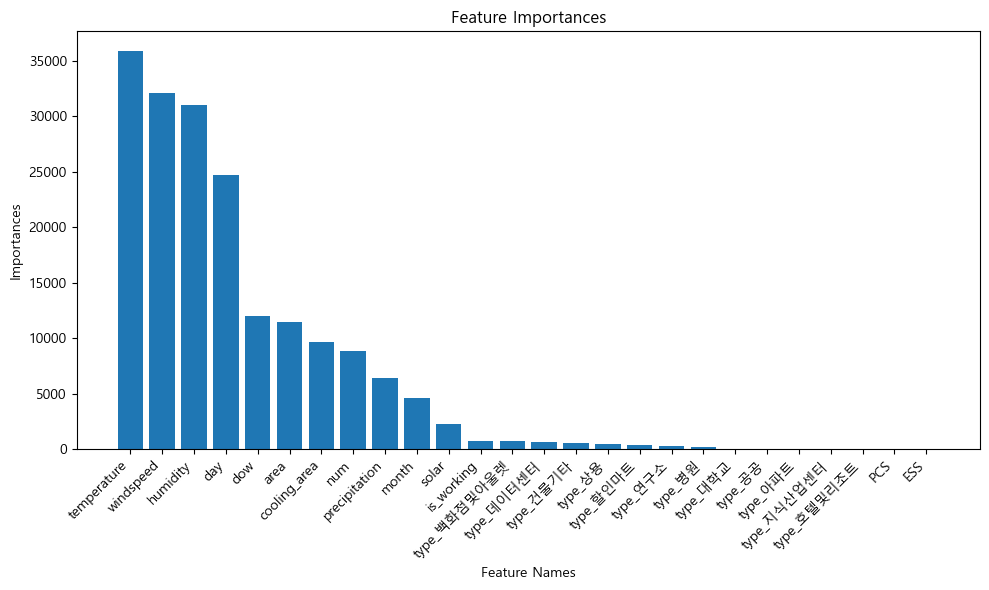

Cluster 2 train is Completed
####################################################################################################


In [56]:
cluster_num_list=[0,1,2]
study_list, base_models, best_models = train_models(cluster_num_list,train,params_list,optuna_params_list)

In [57]:
base_models

[LGBMRegressor(colsample_bytree=0.5, device='gpu', learning_rate=0.23,
               max_depth=10, min_child_samples=10, n_estimators=50,
               num_leaves=1023, random_state=624, reg_lambda=7, verbose=-1),
 LGBMRegressor(colsample_bytree=0.5, device='gpu', learning_rate=0.2,
               max_depth=7, min_child_samples=10, n_estimators=50,
               num_leaves=511, random_state=624, reg_lambda=5, verbose=-1),
 LGBMRegressor(colsample_bytree=0.5, device='gpu', learning_rate=0.3,
               max_depth=12, num_leaves=1023, random_state=624, reg_lambda=5,
               verbose=-1)]

In [58]:
best_models

[LGBMRegressor(colsample_bytree=0.7, device='gpu',
               learning_rate=0.06561788482007107, max_depth=15,
               min_child_samples=10, n_estimators=200, num_leaves=2047,
               random_state=624, reg_lambda=10.273864721431277, verbose=-1),
 LGBMRegressor(colsample_bytree=0.7, device='gpu',
               learning_rate=0.09685276070091228, max_depth=10,
               min_child_samples=15, n_estimators=50, num_leaves=255,
               random_state=624, reg_lambda=7.127610485773211, verbose=-1),
 LGBMRegressor(colsample_bytree=0.7, device='gpu',
               learning_rate=0.09623770599104241, max_depth=15,
               min_child_samples=10, n_estimators=193, num_leaves=2047,
               random_state=624, reg_lambda=7.352125008355374, verbose=-1)]

### 7. 테스트 및 제출 파일 생성

In [59]:
test = pd.read_csv('data/test.csv')
building_info = pd.read_csv('data/building_info.csv')
test.columns = ['num_date_time', 'num', 'date_time', 'temperature', 'precipitation','windspeed', 'humidity']
building_info.columns = ['num', 'type', 'area', 'cooling_area', 'solar', 'ESS', 'PCS']
building_info.replace('-',0,inplace=True)
building_info[building_info.columns.drop('type')]=building_info.drop(['type'],axis=1).apply(lambda x:x.astype('float'))
test = pd.merge(test, building_info, on='num', how='inner')

In [62]:
# test 데이터 결측치 채우기
test.info()
test['precipitation'].fillna(0,inplace=True)
test['windspeed'].interpolate(method='linear',inplace=True)
test['humidity'].interpolate(method='linear',inplace=True)
test.info()

# 건물 전체를 넣어서 모델링하기 위해 건물 타입을 categorical feature로 변환
test=pd.get_dummies(data=test,columns=['type'])
# 시간관련변수 추가
test['date_time'] = pd.to_datetime(test['date_time'])
test['month']=test['date_time'].dt.month
#train['hour']=train['date_time'].dt.hour
test['dow'] = test.date_time.dt.day_of_week # 0 ~ 6 : 월~일
test["day"] = test.date_time.dt.day
test["is_working"] = test.date_time.dt.hour.apply(is_working)
#train["is_weekend"] = train.date_time.dt.day_of_week.apply(is_weekend)
test

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16800 entries, 0 to 16799
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   num_date_time  16800 non-null  object 
 1   num            16800 non-null  int64  
 2   date_time      16800 non-null  object 
 3   temperature    16800 non-null  float64
 4   precipitation  16800 non-null  float64
 5   windspeed      16800 non-null  float64
 6   humidity       16800 non-null  int64  
 7   area           16800 non-null  float64
 8   cooling_area   16800 non-null  float64
 9   solar          16800 non-null  float64
 10  ESS            16800 non-null  float64
 11  PCS            16800 non-null  float64
 12  type_건물기타      16800 non-null  bool   
 13  type_공공        16800 non-null  bool   
 14  type_대학교       16800 non-null  bool   
 15  type_데이터센터     16800 non-null  bool   
 16  type_백화점및아울렛   16800 non-null  bool   
 17  type_병원        16800 non-null  bool   
 18  type_상

num_date_time  num           date_time  temperature  precipitation  \
0        1_20220825 00    1 2022-08-25 00:00:00         23.5            0.0   
1        1_20220825 01    1 2022-08-25 01:00:00         23.0            0.0   
2        1_20220825 02    1 2022-08-25 02:00:00         22.7            0.0   
3        1_20220825 03    1 2022-08-25 03:00:00         22.1            0.0   
4        1_20220825 04    1 2022-08-25 04:00:00         21.8            0.0   
...                ...  ...                 ...          ...            ...   
16795  100_20220831 19  100 2022-08-31 19:00:00         22.5            0.0   
16796  100_20220831 20  100 2022-08-31 20:00:00         20.7            0.0   
16797  100_20220831 21  100 2022-08-31 21:00:00         20.2            0.0   
16798  100_20220831 22  100 2022-08-31 22:00:00         20.1            0.0   
16799  100_20220831 23  100 2022-08-31 23:00:00         19.1            0.0   

       windspeed  humidity       area  cooling_area  solar  ...  type_상용  \
0            2.2        72  110634.00      39570.00    0.0  ...    False   
1            0.9        72  110634.00      39570.00    0.0  ...    False   
2            1.5        75  110634.00      39570.00    0.0  ...    False   
3            1.3        78  110634.00      39570.00    0.0  ...    False   
4            1.0        77  110634.00      39570.00    0.0  ...    False   
...          ...       ...        ...           ...    ...  ...      ...   
16795        0.9        84   57497.84      40035.23    0.0  ...    False   
16796        0.4        95   57497.84      40035.23    0.0  ...    False   
16797        0.4        98   57497.84      40035.23    0.0  ...    False   
16798        1.1        97   57497.84      40035.23    0.0  ...    False   
16799        0.1        99   57497.84      40035.23    0.0  ...    False   

       type_아파트  type_연구소  type_지식산업센터  type_할인마트  type_호텔및리조트  month  dow  \
0         False     False        False      False        False      8    3   
1         False     False        False      False        False      8    3   
2         False     False        False      False        False      8    3   
3         False     False        False      False        False      8    3   
4         False     False        False      False        False      8    3   
...         ...       ...          ...        ...          ...    ...  ...   
16795     False     False        False      False         True      8    2   
16796     False     False        False      False         True      8    2   
16797     False     False        False      False         True      8    2   
16798     False     False        False      False         True      8    2   
16799     False     False        False      False         True      8    2   

       day  is_working  
0       25           0  
1       25           0  
2       25           0  
3       25           0  
4       25           0  
...    ...         ...  
16795   31           1  
16796   31           0  
16797   31           0  
16798   31           0  
16799   31           0  

[16800 rows x 28 columns]

In [65]:
test = pd.merge(test, cluster_info, on='num')

In [66]:
test_idx=[]
preds=[]
for c_num in cluster_num_list:
    X = test[test.cluster == c_num].drop(columns=['num_date_time', 'date_time', 'cluster'])
    pred=best_models[c_num].predict(X)
    X['target']=pred
    test_idx.append(X.index)
    preds.append(pred)

In [68]:
print(preds[0].shape, preds[1].shape, preds[2].shape)

(5208,) (7392,) (4200,)


In [69]:
submission = pd.read_csv('data/sample_submission.csv')
submission.loc[test_idx[0], 'answer'] = preds[0]
submission.loc[test_idx[1], 'answer'] = preds[1]
submission.loc[test_idx[2], 'answer'] = preds[2]
submission.to_csv("submission(12.01)_base.csv", index=False)

C:\Users\DESKTOP\AppData\Local\Temp\ipykernel_21952\1740672886.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[724.3358491  787.53792032 720.72316072 ... 559.08256734 568.49654021
 460.48296352]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  submission.loc[test_idx[0], 'answer'] = preds[0]
